#**Deep Learning Homework 3: Convolutional Neural Networks**
### MSc Computer Science, Data Science, Cybersecurity @UNIPD
### 2nd semester - 6 ECTS
### Prof. Alessandro Sperduti, Prof. Nicolò Navarin and Dr. Luca Pasa
---
In this homework, we will explore how to develop a simple Convolutional Neural Network for image classification. We will use the CIFAR-10 dataset. In the first part, we will learn how to develop a simple CNN, while in the second part we will explore the impact of various hyper-parameters on the learning performances.

# Requirements
Let's start importing the libraries we will need and setting a couple of environmental variables.

**Disclaimer**: the notebook has been tested in Colab with Python `3.9.16`. Some parts *may* not work as expected using different packages and Python versions.

In [47]:
print("You are using:")
!python --version


You are using:
Python 3.9.16


In [48]:
# They've just released torch 2.0, but we will use the more stable torch=1.13 along with other supporting libriaries
!pip3 install pandas~=1.5 torch~=1.13 torchinfo torchdata~=0.5 torchtext~=0.14 torchvision~=0.14 torchaudio~=0.13

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [49]:
import torch
from torch import nn
from torch.nn import Conv2d, MaxPool2d, Linear
from torchinfo import summary
import torch.nn.functional as F
from torchvision.datasets import CIFAR10
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision.transforms import Lambda
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from timeit import default_timer as timer
import warnings
warnings.filterwarnings("ignore") #Conflict of nn.functional.act_f and torch.act_f

print(f"{torch.__version__=}")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"{device=}")
!nvidia-smi --format=csv --query-gpu=index,name,driver_version,memory.total,memory.used,memory.free

# Set seed for reproducibility
torch.manual_seed(43)
rng = np.random.default_rng(seed=4242)

torch.__version__='1.13.1+cu117'
device=device(type='cuda')
index, name, driver_version, memory.total [MiB], memory.used [MiB], memory.free [MiB]
0, Tesla T4, 525.85.12, 15360 MiB, 7923 MiB, 7178 MiB


# Exercise 3.1: Simple CNN

## Data Loading and Preprocessing [TO COMPLETE]


We will use the `CIFAR-10` dataset.The dataset consists of $60.000$ images in $10$ classes, with $6.000$ images per class. There are $50.000$ training images and $10.000$ test images. Each sample is a $32\times32$ pixels color image (thus with an extra $\times3$ dimensions for the colors channels), associated with a label from one of the classes:

```python
classes = ["airplane", "automobile", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck"]
```

We will divide the dataset in training, testing and validation set. As you already know, the training set will be used to train the model, the validation set will be used to perform model selection and finally, the test set will be used to asses the performance of deep network.

**[TO COMPLETE]**

In the standard dataset, each pixel intensity is represented by a `uint8` (byte) from $0$ to $255$. As a preprocessing step, we will rescale these values in the range $[0,1]$. You should write a simple so-called MinMaxScaler which takes as input a PIL Image (a specific format for images in Python) and rescales it, after making the appropriate type and shape transformations.

`%STARTCODE`

In [50]:
def MinMaxScaler(img):#[TO COMPLETE]
  # First, we load the data as numpy array
  img_as_array = np.asarray(img)
  # TO COMPLETE: Transform the array to Tensor for PyTorch
  img_as_tensor = torch.from_numpy(img_as_array)
  # TO COMPLETE: image is of size (Height, Width, Channels). But torch excepts (C, H, W). Hence, the second thing is to permute.
  img_as_tensor = img_as_tensor.permute(2, 0, 1).contiguous()
  # TO COMPLETE: Rescale image pixels form [0,255] to [0,1]
  normalized_img = (img_as_tensor - torch.min(img_as_tensor)) / (torch.max(img_as_tensor) - torch.min(img_as_tensor))
  return normalized_img


'''
NEW DATA LOADING
Note that the previous function must be passed to transforms.Lambda().
'''
dataset = CIFAR10(root='data/', download=True, train=True, transform=transforms.Lambda(MinMaxScaler)) # 50000 samples
test_data = CIFAR10(root='data/', download=True, train=False, transform=transforms.Lambda(MinMaxScaler)) # 10000 samples

Files already downloaded and verified
Files already downloaded and verified


`%ENDCODE`

In [51]:
# Let's check the classes and dataset shapes:
classes = dataset.classes
print(f"{classes=}")
print(f"Dataset shape: {dataset.data.shape}")
print(f"Test set shape: {test_data.data.shape}")

classes=['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
Dataset shape: (50000, 32, 32, 3)
Test set shape: (10000, 32, 32, 3)


In [52]:
dataset

Dataset CIFAR10
    Number of datapoints: 50000
    Root location: data/
    Split: Train
    StandardTransform
Transform: Lambda()

In [53]:
# Let's also check whether the dataset is balanced, i.e. there are the same amount of samples for each class
label_count = {}
for _, idx in dataset:
    label = classes[idx]
    if label not in label_count:
        label_count[label] = 0
    label_count[label] += 1
label_count

{'frog': 5000,
 'truck': 5000,
 'deer': 5000,
 'automobile': 5000,
 'bird': 5000,
 'horse': 5000,
 'ship': 5000,
 'cat': 5000,
 'dog': 5000,
 'airplane': 5000}

We split the dataset into training/validation sets:

In [54]:
val_size = 5000
train_size = len(dataset) - val_size

train_data, val_data = random_split(dataset, [train_size, val_size])
print(f"Training samples = {len(train_data)} \nValidation samples = {len(val_data)} \nTest samples = {len(test_data)}")

Training samples = 45000 
Validation samples = 5000 
Test samples = 10000


Let's see how normalized sample looks like...

In [55]:
idx = 50 # 51st data sample
print(train_data[idx]) # (image, label) tensors
assert train_data[idx][0].max().item() <= 1., "Check your MinMaxScaler!"

(tensor([[[0.7059, 0.6878, 0.6923,  ..., 0.7692, 0.7692, 0.7647],
         [0.6878, 0.6697, 0.6787,  ..., 0.7511, 0.7466, 0.7466],
         [0.7059, 0.6923, 0.6878,  ..., 0.7285, 0.7240, 0.7195],
         ...,
         [0.7330, 0.7330, 0.7376,  ..., 0.7376, 0.7511, 0.7421],
         [0.7828, 0.7783, 0.7828,  ..., 0.7964, 0.7964, 0.7783],
         [0.8054, 0.7964, 0.7964,  ..., 0.7692, 0.7783, 0.7557]],

        [[0.6516, 0.6380, 0.6425,  ..., 0.7195, 0.7195, 0.7149],
         [0.6380, 0.6199, 0.6290,  ..., 0.7014, 0.6968, 0.6968],
         [0.6561, 0.6425, 0.6380,  ..., 0.6787, 0.6742, 0.6697],
         ...,
         [0.6787, 0.6742, 0.6787,  ..., 0.6787, 0.6923, 0.6833],
         [0.7285, 0.7285, 0.7330,  ..., 0.7466, 0.7466, 0.7285],
         [0.7557, 0.7466, 0.7466,  ..., 0.7195, 0.7285, 0.7059]],

        [[0.6335, 0.6199, 0.6244,  ..., 0.7014, 0.7014, 0.6968],
         [0.6154, 0.6018, 0.6109,  ..., 0.6833, 0.6787, 0.6787],
         [0.6380, 0.6244, 0.6199,  ..., 0.6606, 0.6561, 0

... it's better to see it as images!

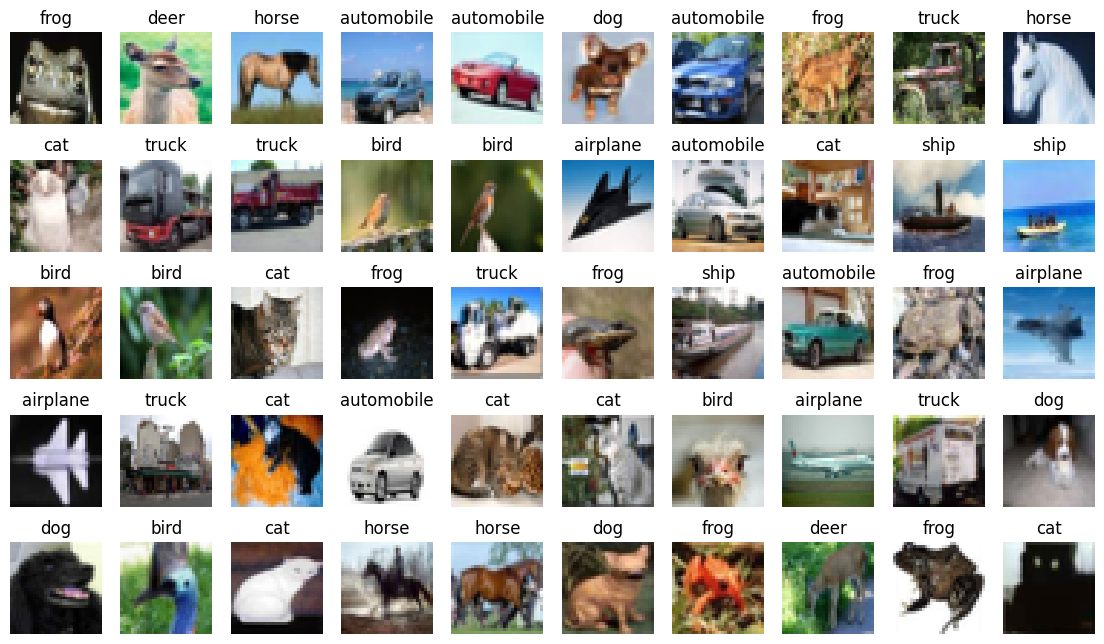

In [56]:
img_chan, img_height, img_width = train_data[idx][0].shape #Channel, Height, Width

# Plots
n_rows = 5
n_cols = 10
plt.figure(figsize=(n_cols*1.4, n_rows * 1.6))
for row in range(n_rows):
    for col in range(n_cols):
        index = n_cols * row + col
        plt.subplot(n_rows, n_cols, index + 1)
        image, label = train_data[index]
        image = image.permute((1, 2, 0)) #C,H,W -> H,W,C
        plt.imshow(image, cmap="binary", interpolation="nearest")
        plt.axis('off')
        plt.title(classes[label])
plt.show()

Explain in the cell below when using Gradient Descent, why it is usually a good idea to ensure that all the features have a similar scale. 

`%STARTEXT`

Answer: **[TO COMPLETE]**

Different ranges of the features will cause different step sizes in the gradient descent algorithm for each feature. If one feature has much larger values than the others, it can dominate the cost function as it will contribute to a higher variance in the predictions.

To ensure that gradient descent moves smoothly towards the minima and that the steps for gradient descent are updated at the same rate for all the features, it is a good practice to scale the data.

This can lead to faster training, better error surface shape and it can prevent the optimization from getting stuck in local optima.


`%ENDTEXT`

Since `train_data`, `val_data` and `test_data` are already PyTorch Datasets, we can use directly DataLoaders to load data from them.

In [57]:
batch_size = 256
dataloader_training = DataLoader(train_data, batch_size=batch_size, shuffle=True)
dataloader_validation = DataLoader(val_data, batch_size=batch_size)
dataloader_test = DataLoader(test_data, batch_size=batch_size)

##Model Definition and Training

Let's create a simple CNN. The model will be composed of:
* One 2D convolutional layer with kernel size 3x3 and 32 output filters/features, that use ReLU activation function
* a Max Pooling layer (2D) of size 2x2.
* a Flatten layer
* a final Dense layer with 10 output neurons (one per class). We do not need to normalize or transform further the outputs, as the `CrossEntropyLoss` takes care of that. Another equivalent approach would be to add a `LogSoftmax` final layer that returns log-probabilities and then use the `NegativeLogLikelihoodLoss`., and with the _softmax_ activation function to ensure that the sum of all the estimated class probabilities for each image is equal to 1.
Note that as `input_shape` attribute's value in the first layer report also the third dimension that represents the channel.

In [58]:
class My_Convolutional_Network(nn.Module):
  def __init__(self, conv_filters=[], kernel_sizes=[], max_pool_sizes=[], act_fs=[], verbose=False):
    super().__init__()

    assert len(conv_filters) == len(kernel_sizes), "length of {conv_filters} and {kernel_sizes} must be same"
    assert len(conv_filters) == len(max_pool_sizes), "length of {conv_filters} and {max_pool_sizes} must be same"
    # max pool of [1, 1] corresponds to no max pool
    assert len(conv_filters) == len(act_fs), "length of {conv_filters} and {act_fs} must be same"

    self.conv_layers = nn.ModuleList()
    self.max_pools = nn.ModuleList()
    self.in_chan = img_chan
    self.in_height = img_height
    self.in_width = img_width
    self.output_dim = len(classes)#10
    self.verbose = verbose
    self.act_fs = act_fs

    height_dimension = self.in_height
    width_dimension = self.in_width

    for maxp1, maxp2 in max_pool_sizes: # as long as padding='same'
      height_dimension = height_dimension // maxp1
      width_dimension = width_dimension // maxp2

    self.inp_dim_to_linear = conv_filters[-1] * height_dimension * width_dimension

    for idx in range(len(conv_filters)):
      if idx == 0:
        #Conv2d(in_channels, out_channels, kernel_size, padding)
        self.conv_layers = self.conv_layers.append(Conv2d(self.in_chan, conv_filters[idx],
                                                          kernel_sizes[idx], padding='same'))
      else:
        self.conv_layers = self.conv_layers.append(Conv2d(conv_filters[idx-1], conv_filters[idx],
                                                          kernel_sizes[idx], padding='same'))
        
      self.max_pools = self.max_pools.append(MaxPool2d(max_pool_sizes[idx]))
    
    self.linear = Linear(self.inp_dim_to_linear, self.output_dim)

  def forward(self, x):

    for idx in range(len(self.conv_layers)):
      from_shape = x.shape[1:]
      active_conv_layer = self.conv_layers[idx]
      active_max_pool = self.max_pools[idx]
      active_act_fun = self.act_fs[idx]
      x = active_max_pool(active_act_fun(active_conv_layer(x)))
      to_shape = x.shape[1:]

      if self.verbose:
        print(f'From dimension [{from_shape}] to dimension [{to_shape}]')

    x = torch.flatten(x, start_dim=1) #if start_dim=1 missed, it also consider batch_size

    if self.verbose:
        print(f'From dimension [{to_shape}] to dimension [{x.shape[1:]}]')
        print(f'From dimension [{x.shape[1:]}] to dimension [{self.output_dim}]')

    return self.linear(x) #no need to use softmax because of the loss function

In [59]:
conv_filters = [32]
kernel_sizes = [[3, 3]]
max_pool_sizes = [[2, 2]]
act_fs = [F.relu]

num_epochs = 20
lr = 1e-3
model = My_Convolutional_Network(conv_filters, kernel_sizes, max_pool_sizes,
                                 act_fs, False).to(device)
summary(model, input_size=(batch_size, 3, 32, 32)) # Here is a nice summary of our model!

Layer (type:depth-idx)                   Output Shape              Param #
My_Convolutional_Network                 [256, 10]                 --
├─ModuleList: 1-1                        --                        --
│    └─Conv2d: 2-1                       [256, 32, 32, 32]         896
├─ModuleList: 1-2                        --                        --
│    └─MaxPool2d: 2-2                    [256, 32, 16, 16]         --
├─Linear: 1-3                            [256, 10]                 81,930
Total params: 82,826
Trainable params: 82,826
Non-trainable params: 0
Total mult-adds (M): 255.86
Input size (MB): 3.15
Forward/backward pass size (MB): 67.13
Params size (MB): 0.33
Estimated Total Size (MB): 70.61

Note that the number of parameters mostly depends on the output layers, indeed the parameter sharing techinique used by the 2D convolutional layers allows to significantly reduce the number of learnable weights.
Now we can train the model.

In [60]:
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

In [61]:
def train(model, optimizer, dataloader_train, dataloader_val, epochs):
  loss_train, loss_val = [], []
  acc_train, acc_val = [], []
  for epoch in range(epochs):

    model.train()
    total_acc_train, total_count_train, n_train_batches, total_loss_train = 0, 0, 0, 0
    for idx, (img, label) in enumerate(dataloader_train):
      img, label = img.to(device), label.to(device)
      optimizer.zero_grad()
      logits = model(img)
      loss = criterion(logits, label)
      total_loss_train += loss
      loss.backward()
      optimizer.step()

      total_acc_train += (logits.argmax(1) == label).sum().item()
      total_count_train += label.size(0)
      n_train_batches += 1

    avg_loss_train = total_loss_train/n_train_batches
    loss_train.append(avg_loss_train.item())
    accuracy_train = total_acc_train/total_count_train
    acc_train.append(accuracy_train)
    
    total_acc_val, total_count_val, n_val_batches, total_loss_val = 0, 0, 0, 0
    with torch.no_grad():
        model.eval()
        for idx, (img, label) in enumerate(dataloader_val):
            img, label = img.to(device), label.to(device)
            logits = model(img)
            loss = criterion(logits, label)
            total_loss_val += loss
            total_acc_val += (logits.argmax(1) == label).sum().item()
            total_count_val += label.size(0)
            n_val_batches += 1
    avg_loss_val = total_loss_val/n_val_batches
    loss_val.append(avg_loss_val.item())
    accuracy_val = total_acc_val/total_count_val
    acc_val.append(accuracy_val) 
    if epoch % 1 == 0:
      print(f"epoch: {epoch+1} -> Accuracy: {100*accuracy_train:.2f}%, Loss: {avg_loss_train:.8f}",end=" ---------------- ")
      print(f"Val_Acc: {100*accuracy_val:.2f}%, Val_Loss: {avg_loss_val:.8f}")
  return loss_train, acc_train, loss_val, acc_val

In [62]:
start = timer()
loss_train, accuracy_train, loss_val, accuracy_val = train(model, optimizer, dataloader_training, dataloader_validation, epochs = num_epochs)
end = timer()
print(f"Training time in second: {(end - start)}")

epoch: 1 -> Accuracy: 40.91%, Loss: 1.68858814 ---------------- Val_Acc: 49.06%, Val_Loss: 1.49524009
epoch: 2 -> Accuracy: 52.76%, Loss: 1.37514997 ---------------- Val_Acc: 53.06%, Val_Loss: 1.35879779
epoch: 3 -> Accuracy: 56.85%, Loss: 1.25439191 ---------------- Val_Acc: 55.78%, Val_Loss: 1.27848852
epoch: 4 -> Accuracy: 59.63%, Loss: 1.17742288 ---------------- Val_Acc: 57.86%, Val_Loss: 1.21295106
epoch: 5 -> Accuracy: 61.56%, Loss: 1.12107337 ---------------- Val_Acc: 57.80%, Val_Loss: 1.21054065
epoch: 6 -> Accuracy: 62.99%, Loss: 1.07921600 ---------------- Val_Acc: 59.30%, Val_Loss: 1.16426635
epoch: 7 -> Accuracy: 63.98%, Loss: 1.04356909 ---------------- Val_Acc: 60.56%, Val_Loss: 1.13581502
epoch: 8 -> Accuracy: 65.17%, Loss: 1.01675665 ---------------- Val_Acc: 61.22%, Val_Loss: 1.12780797
epoch: 9 -> Accuracy: 65.96%, Loss: 0.99237341 ---------------- Val_Acc: 61.64%, Val_Loss: 1.11600304
epoch: 10 -> Accuracy: 67.07%, Loss: 0.96646756 ---------------- Val_Acc: 60.94%, 

In [63]:
def plot_learning_acc_and_loss(loss_tr, acc_tr, loss_val, acc_val):

    plt.figure(figsize=(8, 10))

    plt.subplot(2, 1, 1)
    plt.grid()
    plt.plot(range(num_epochs), acc_tr, label='acc_training')
    plt.plot(range(num_epochs), acc_val, label='acc_validation')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend(loc='best')

    plt.subplot(2, 1, 2)
    plt.grid()
    plt.plot(range(num_epochs), loss_tr, label='loss_training')
    plt.plot(range(num_epochs), loss_val, label='loss_validation')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend(loc='best')

    plt.show()

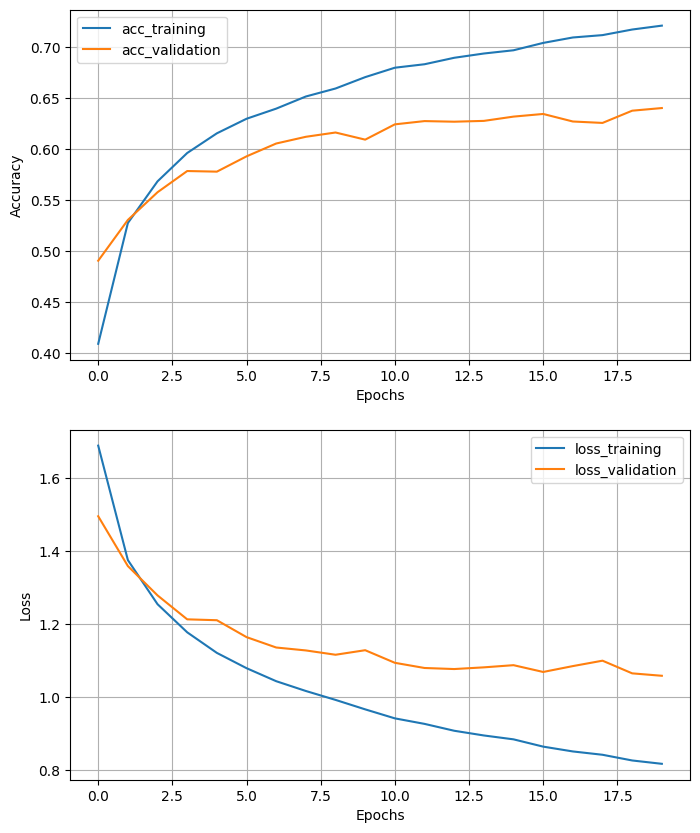

In [64]:
plot_learning_acc_and_loss(loss_train, accuracy_train, loss_val, accuracy_val)

Finally, we test the model:

In [65]:
def test(model, dataloader_test=dataloader_test):
  model.eval()
  total_acc_test, total_count_test, n_batches_test, loss = 0, 0, 0, 0
  for idx, (img, label) in enumerate(dataloader_test):
      img, label = img.to(device), label.to(device)
      logits = model(img)
      loss += criterion(logits, label)
      total_acc_test += (logits.argmax(1) == label).sum().item()
      total_count_test += label.size(0)
      n_batches_test += 1
  accuracy_test = total_acc_test/total_count_test
  loss_test = loss/n_batches_test
  print(f"Test Loss: {loss_test:.8f}", end=' ---------- ')
  print(f"Test Accuracy: {100*accuracy_test:.4f}%")

In [66]:
test(model)

Test Loss: 1.03897858 ---------- Test Accuracy: 64.5000%


Here we see that the test accuracy of our simple CNN is about 64%.

## Visualize filters
Let's now visualize the filters emerged in the first convolutional layer.

In [67]:
layer_names = []
weights = {}
for name, param in model.named_parameters():
    if param.requires_grad:
        layer_names.append(name)
        weights.setdefault(name, param.data)

conv_weights = weights['conv_layers.0.weight']
print(f"{conv_weights.shape=} <=> [out_dim, inp_dim, kernel_size[0], kernel_size[1]]")

conv_weights.shape=torch.Size([32, 3, 3, 3]) <=> [out_dim, inp_dim, kernel_size[0], kernel_size[1]]


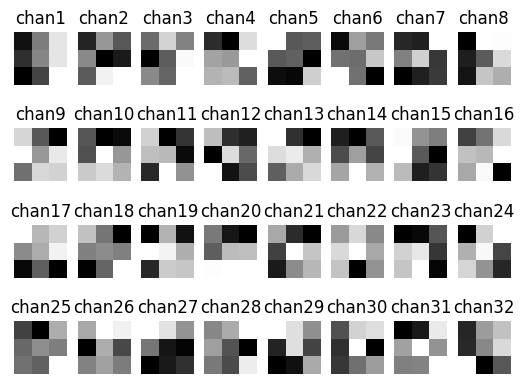

In [68]:
conv_w0 = conv_weights[:, 0, :, :] # Pick one input dimension

# Rescale weights for visualization
conv_w0 -= torch.min(conv_w0)
conv_w0 /= torch.max(conv_w0)

for r in range(4):
    for c in range(8):
        n=r*8+c
        plt.subplot(4, 8, n+1)
        plt.imshow(conv_w0[n,:,:].cpu(), interpolation='none')
        plt.title(f'chan{n+1}')
        plt.axis('off')
        plt.gray()
plt.show()

They might be a bit hard to interpret, but it seems that the various filters have learned to detect various corners and edges.

## Parameters of a CNN [TO COMPLETE]

Explain in the cell below:

1. How are the number of parameters for Conv2D layers are determined? Perform the calculations to calculate the parameters of the Conv2D layer. 

`%STARTEXT`

Answer1 : **[TO COMPLETE]**

The number of parameters for Conv2D layers are determined using the following  formula:
```
num_params = (filter_width * filter_height * num_input_channels + 1) * num_filters
```
In this case:
```
num_params_1 = (3 * 3 * 3 + 1) * 32 = 896
```

`%ENDTEXT`

# Exercise 3.2: Deep CNN


Let's consider a deeper model, more precisly in this exercise we consider a model composed of:
* One 2D convolutional layer with kernel size 3x3 and 32 output filters/features, that use ReLu activation function
* a Max Pooling layer (2D) of size 2x2 
* One 2D convolutional layer with kernel size 2x2 and 16 output filters/features, that use ReLu activation function
* a Max Pooling layer (2D) of size 2x2
* a Flatten layer
* a final Dense layer with 10 output neurons (one per class), and with the _softmax_ activation function


In [69]:
conv_filters = [32, 16]
kernel_sizes = [[3, 3], [2, 2]]
max_pool_sizes = [[2, 2], [2, 2]]
act_fs = [F.relu, F.relu]

num_epochs = 20
lr = 1e-3
deep_model = My_Convolutional_Network(conv_filters, kernel_sizes, max_pool_sizes,
                                      act_fs, False).to(device)
summary(deep_model, input_size=(batch_size, 3, 32, 32)) # Here is a nice summary of our model!

Layer (type:depth-idx)                   Output Shape              Param #
My_Convolutional_Network                 [256, 10]                 --
├─ModuleList: 1-3                        --                        (recursive)
│    └─Conv2d: 2-1                       [256, 32, 32, 32]         896
├─ModuleList: 1-4                        --                        --
│    └─MaxPool2d: 2-2                    [256, 32, 16, 16]         --
├─ModuleList: 1-3                        --                        (recursive)
│    └─Conv2d: 2-3                       [256, 16, 16, 16]         2,064
├─ModuleList: 1-4                        --                        --
│    └─MaxPool2d: 2-4                    [256, 16, 8, 8]           --
├─Linear: 1-5                            [256, 10]                 10,250
Total params: 13,210
Trainable params: 13,210
Non-trainable params: 0
Total mult-adds (M): 372.77
Input size (MB): 3.15
Forward/backward pass size (MB): 75.52
Params size (MB): 0.05
Estimated Total S

In [70]:
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(deep_model.parameters(), lr=lr)

In [71]:
start = timer()
loss_train, accuracy_train, loss_val, accuracy_val = train(deep_model, optimizer, dataloader_training, dataloader_validation, epochs = num_epochs)
end = timer()
print(f"Training time in second: {(end - start)}")

epoch: 1 -> Accuracy: 35.28%, Loss: 1.83387756 ---------------- Val_Acc: 42.54%, Val_Loss: 1.62351763
epoch: 2 -> Accuracy: 47.05%, Loss: 1.49949300 ---------------- Val_Acc: 48.30%, Val_Loss: 1.44713640
epoch: 3 -> Accuracy: 52.01%, Loss: 1.36280811 ---------------- Val_Acc: 52.86%, Val_Loss: 1.35228205
epoch: 4 -> Accuracy: 54.74%, Loss: 1.28853607 ---------------- Val_Acc: 53.50%, Val_Loss: 1.29658294
epoch: 5 -> Accuracy: 56.61%, Loss: 1.23752809 ---------------- Val_Acc: 55.98%, Val_Loss: 1.26196826
epoch: 6 -> Accuracy: 57.95%, Loss: 1.20816290 ---------------- Val_Acc: 56.70%, Val_Loss: 1.23770738
epoch: 7 -> Accuracy: 58.94%, Loss: 1.17771363 ---------------- Val_Acc: 56.40%, Val_Loss: 1.22449279
epoch: 8 -> Accuracy: 59.76%, Loss: 1.15422654 ---------------- Val_Acc: 58.08%, Val_Loss: 1.18554962
epoch: 9 -> Accuracy: 61.01%, Loss: 1.12146187 ---------------- Val_Acc: 58.88%, Val_Loss: 1.17099369
epoch: 10 -> Accuracy: 61.24%, Loss: 1.11095917 ---------------- Val_Acc: 57.88%, 

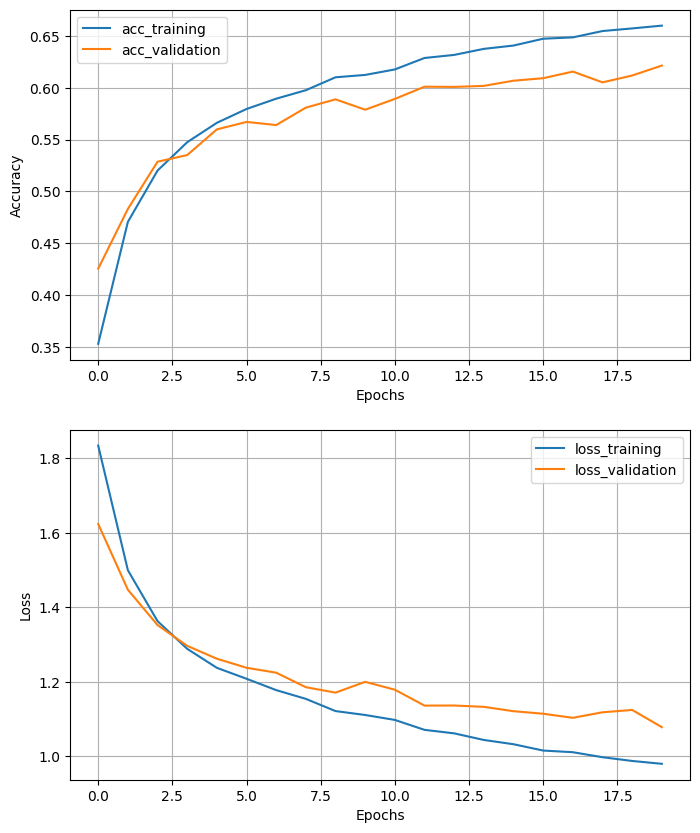

In [72]:
plot_learning_acc_and_loss(loss_train, accuracy_train, loss_val, accuracy_val)

In [73]:
test(deep_model)

Test Loss: 1.03784585 ---------- Test Accuracy: 64.0300%


Whoa! By developing the deep CNN we dropped the accuracy fom ~64% to ~62%. It seems like we need to develop a better CNN model. 

# Exercise 3.3: A better CNN [TO COMPLETE]

Let's develop a network that performs better than the very simple one above. This exercise aims to explore how much the various hyper-parameters influence the classification capability of the model. 

**[TO COMPLETE]**: Your task is to modify some of the hyper-parameters of the previous exercise's network and compare the results. At least one of the models you try should have an improvement in the test set results (generalization) over the result of the model used in the previous exercise.
In the cell below report only the code of the **best model** that you can find. In addtion, print out its result on the test set, and plot the accuracy and the loss trends in the notebook you return.
Moreover, for each setup you test, analyze and discuss the obtained results briefly in the last cells at the bottom.

Hint: Each reparameterization should change a different aspect in the network, while the rest of the parameters would stay the same. 
Example parameters to try to change (we suggest to test at least one re-parametrization for each of these categories):

*    number of layers or neurons or filters dimension
*   activation functions
*   epochs
*   batch sizes
*   max-pooling on/off on certain layers, or pool size

`%STARTCODE`

Layer (type:depth-idx)                   Output Shape              Param #
My_Convolutional_Network                 [256, 10]                 --
├─ModuleList: 1-5                        --                        (recursive)
│    └─Conv2d: 2-1                       [256, 32, 32, 32]         896
├─ModuleList: 1-6                        --                        --
│    └─MaxPool2d: 2-2                    [256, 32, 16, 16]         --
├─ModuleList: 1-5                        --                        (recursive)
│    └─Conv2d: 2-3                       [256, 64, 16, 16]         18,496
├─ModuleList: 1-6                        --                        --
│    └─MaxPool2d: 2-4                    [256, 64, 8, 8]           --
├─ModuleList: 1-5                        --                        (recursive)
│    └─Conv2d: 2-5                       [256, 128, 8, 8]          73,856
├─ModuleList: 1-6                        --                        --
│    └─MaxPool2d: 2-6                    [256, 12

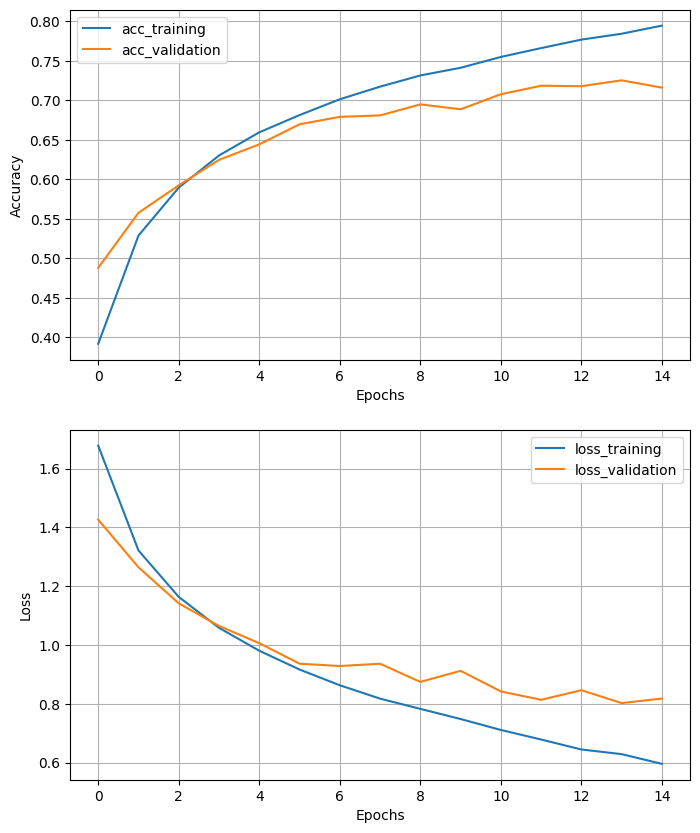


Testing the model on the test dataset...
Test Loss: 0.80498213 ---------- Test Accuracy: 73.0200%


In [74]:
# TO COMPLETE
batch_size = 256
# batch_size = 128
dataloader_training = DataLoader(train_data, batch_size=batch_size, shuffle=True)
dataloader_validation = DataLoader(val_data, batch_size=batch_size)
dataloader_test = DataLoader(test_data, batch_size=batch_size)

conv_filters = [32, 64, 128]
kernel_sizes = [[3, 3], [3, 3], [3, 3]]
max_pool_sizes = [[2, 2], [2, 2], [2, 2]]
act_fs = [F.relu, F.relu, F.relu]

num_epochs = 15
lr = 1e-3
best_deep_model = My_Convolutional_Network(conv_filters, kernel_sizes, max_pool_sizes,
                                      act_fs, False).to(device)
print(summary(best_deep_model, input_size=(batch_size, 3, 32, 32)))

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(best_deep_model.parameters(), lr=lr)

print("\nTraining started...")
start = timer()
loss_train, accuracy_train, loss_val, accuracy_val = train(best_deep_model, optimizer, dataloader_training, dataloader_validation, epochs=num_epochs)
end = timer()
print(f"Training time in second: {(end - start)}")

print("\nPlotting loss and accuracy trends for train and validation datasets...")
plot_learning_acc_and_loss(loss_train, accuracy_train, loss_val, accuracy_val)

print("\nTesting the model on the test dataset...")
test(best_deep_model)

`%ENDCODE`

# [TO COMPLETE] Discuss your results

In the discussion, you need to clearly motivate your choice of hyperparameters, what work and what did not work. 
You also need to plot all the results of experiments you have conducted. 

`%STARTEXT`

The best model that I found is... the model with 3 2D convolutional layers (followed by the usual flatten layer and final dense layer):
- First conv layer: 
    - kernel size 3x3
    - 32 output filters/features
    - ReLU activation function
    - Max Pooling layer (2D) of size 2x2
- Second conv layer: 
    - kernel size 3x3
    - 64 output filters/features
    - ReLU activation function
    - Max Pooling layer (2D) of size 2x2
- Third conv layer: 
    - kernel size 3x3
    - 128 output filters/features
    - ReLU activation function
    - Max Pooling layer (2D) of size 2x2
- Learning rate: 1e-3
- Batch size: 256
- Epochs: 15

The achieved accuracy in the test set is... on average 72% 

Discussion:

After testing at least one re-parametrization for each category and comparing the results with previous models, I identified the parameters that improved the model's performance.
Following that, I built the model that appears to produce the greatest outcomes iteratively.

I fixed the size of the filters to 3x3. Smaller filters lose too much information.
3x3 filters are preferred over larger filter sizes since they can perform the same computation as larger filters but with fewer parameters and computations. Larger filters (7x7) may improve the accuracy to some extent, but at the cost of increased computational complexity due to larger number of model parameters. In addition, in this case larger filters do not add too much value because the images are not very large and the resolution is not very high. I tested odd-valued filter sizes to prevent zero padding along any input dimension. 3x3 filters is a good balance between computational complexity and accuracy.

I increased the number of convolutional layers (3) and the number of output filters for each layer (32, 64, 128).

Max Pooling is crucial for good results in this case. In fact, among other things, it reduces the number of parameters in the model and thus reduces overfitting. The size 2x2 is a robust choice.
Images are relatively small and the objects of interest are not very large or complex, thus using Max Pooling is beneficial to downsample the spatial feature maps, retain the most informative features and to introduce some degree of translation invariance in the model.

The model tends to overfit. For this it is essential to stop the training around 15 epochs.
I don't believe it is the aim of the homework to improve the model by adding regularization (L1 or L2), but it is certainly something to consider in a real-world project (given the obvious overfitting). Furthermore, in a real-world project, it would be appropriate to use batch normalization to speed up the training process and improve the stability by allowing higher learning rates, reducing the impact of weight initialization and improving the convergence of the model. 

I believe that 1e-3 is the sweet spot for the learning rate. The model is using the Adam optimizer, so I can use a higher learning rate (compared to other optimization algorithms such as SGD and RMSprop). This is because of the adaptive learning rates that are calculated by Adam which can help in smooth optimization and quick convergence.
Therefore I decided to use 1e-3 to speed up convergence (compared to 1e-4).

The batch size depends on several factors, including the hardware, the memory available on GPU or CPU and the complexity of the model architecture. Large batch sizes require more memory but can facilitate better weight updates by taking a more stable direction towards the optimum. On the other hand, small batch sizes require less memory but since the weights are updated more frequently due to smaller batch size, parameter updates might suffer from higher variance which in turn might cause slower convergence to optimum.
Both 128 and 256 are good choices. Since memory is enough, larger batch sizes can theoretically (there are still some problems to be taken into account) lead to better generalization and faster convergence towards a good solution. So, I decided to choose 256 as batch size.

ReLU and its variants are the most commonly used activation functions for CNNs because they are easy to compute, they allow the model to learn sparse representations and they tend to perform well in practice.
ELU can be useful when there are some serious concerns about the saturation of the activation function (when input is very large or very small).
LeakyReLU can be a good option when the input is negative because it can help to reduce the risk of dying ReLU (many neurons get stuck with values equal to zero and stop contributing to the output).
I chose to keep the ReLU activation function because both Leaky ReLU and ELU do not bring additional performance and thus makes sense to choose the simpler function.

Besides, I tested also other models: 
* decreasing the size of the filters (2x2)
* increasing the size of the filters (≥ 7x7)
* adding more than 3 convolutional layers and pooling layers
* lowering the learning rate (1e-4)
* increasing the learning rate (1e-2)
* lowering number of epochs (< 10)
* increasing number of epochs (> 20)
* using ELU as activation function
* using LeakyReLU as activation function
* lowering the batch size (128)
* removing some pooling layers
* changing the pool size (> 2x2)


Discussion:

All these models did not lead to an increase in performance. 

Descreasing the size of the filters (2x2) entails the loss of too much information.
On the other hand, larger filter sizes (≥ 7x7) can allow the network to perceive a larger context of the input image but this can also lead to a descrease in the fidelity of the features being detected (loss of spatial resolution). In addition they require more parameters and they are prone to overfitting (less flexible to handle variations in the dataset). Moreover, as I said before, CIFAR-10 images are relatively small and contain simple shapes and patterns. That's why the peformance does not improve.

Adding more than 3 convolutional layers and pooling layers caused excessive overfitting. The model became too much computationally expensive and the training slowed down badly.

Lowering the learning rate (1e-4) resulted in a very slow convergence with a reduced generalization performance.
On the other hand, increasing too much the learning rate (1e-2) induced instable training, making more difficult to fine-tine the hyperparameters.

Reducing the number of epochs below 10 resulted in lower accuracy and underfitting (the model was not complex enough to capture the patterns in the data).
However, increasing the number of epochs above 20 resulted in overfitting. As a result, additional training time did not result in improved generalization and accuracy.

Using ELU and LeakyReLU did not result in improved model performance.

Both 128 and 256 are good choices for the batch size. In the end, since the memory and the hardware are enough, 256 tends to provide more stable gradients (less noisy) which leads to faster convergence.

Smaller max pool size can retain more spatial information but require more computational resources, while a larger size can reduce spatial resolution and increase computational efficiency but may lead to information loss. Sizes larger than 3x3 led to an excessive downsampling (loss of information) and to a more complex model (prone to overfiting).

`%ENDTEXT`

# Transfer Learning with ResNet18 + ImageNet

Let's now experiment with transfer learning. We will now load the model structure and weights of a small [ResNet](https://en.wikipedia.org/wiki/Residual_neural_network) (which is still pretty big!), pretrained on the ImageNet dataset. We will then add a fully connected layer at the end of the network and fine-tune it on the CIFAR10 dataset. In this way, we can leverage the knowledge already present in the pre-trained weight and transfer it on our task!

In [75]:
from torchvision.models import resnet18, ResNet18_Weights

In [76]:
RESNET18 = resnet18(pretrained=True)
summary(RESNET18, input_size=(batch_size, 3, 32, 32))

Layer (type:depth-idx)                   Output Shape              Param #
ResNet                                   [256, 1000]               --
├─Conv2d: 1-1                            [256, 64, 16, 16]         9,408
├─BatchNorm2d: 1-2                       [256, 64, 16, 16]         128
├─ReLU: 1-3                              [256, 64, 16, 16]         --
├─MaxPool2d: 1-4                         [256, 64, 8, 8]           --
├─Sequential: 1-5                        [256, 64, 8, 8]           --
│    └─BasicBlock: 2-1                   [256, 64, 8, 8]           --
│    │    └─Conv2d: 3-1                  [256, 64, 8, 8]           36,864
│    │    └─BatchNorm2d: 3-2             [256, 64, 8, 8]           128
│    │    └─ReLU: 3-3                    [256, 64, 8, 8]           --
│    │    └─Conv2d: 3-4                  [256, 64, 8, 8]           36,864
│    │    └─BatchNorm2d: 3-5             [256, 64, 8, 8]           128
│    │    └─ReLU: 3-6                    [256, 64, 8, 8]           --
│

The ResNet has a final fully connected layer that generates 1000 logits corresponding to the classes in the ImageNet dataset. We will re-define it and make it map the features learned in the previous layer to the 10 classes of the CIFAR10 datset. 

In [77]:
linear_layer_input = RESNET18.fc.in_features
linear_layer_output = RESNET18.fc.out_features
print(f"Last layer: {linear_layer_input} -> {linear_layer_output}")

Last layer: 512 -> 1000


In [78]:
# Replace  the last layer
RESNET18.fc = Linear(linear_layer_input, 10)

In [79]:
linear_layer_input = RESNET18.fc.in_features
linear_layer_output = RESNET18.fc.out_features
print(f"Last layer: {linear_layer_input} -> {linear_layer_output}")

Last layer: 512 -> 10


Finally, we "freeze" the other weights in the network so that only the ones in the last layer are trainable.

In [80]:
for name, param in RESNET18.named_parameters():
    if name == 'fc.weight' or name == 'fc.bias':
      param.requires_grad = True
    else:
      param.requires_grad = False

In [81]:
RESNET18 = RESNET18.to(device) # Let's now load it to GPU

Let's consider a smaller subset of CIFAR10 in order to speed-up the fine-tuning process:

In [82]:
train_idxs = list(range(0, len(train_data), 5))  # 45000/5=9000 Tr
val_idxs = list(range(1, len(val_data), 5))  # 5000/5=1000 Val
test_idxs = list(range(1, len(test_data), 5))  # 10000/5=2000 Ts

train_data_sub = torch.utils.data.Subset(train_data, train_idxs)
val_data_sub = torch.utils.data.Subset(val_data, val_idxs)
test_data_sub = torch.utils.data.Subset(test_data, test_idxs)

In order to apply custom preprocessing steps that are expected by the pretrained model, we will define a small wrapper around the CIFAR10 dataset.

In [83]:
weights = ResNet18_Weights.DEFAULT
preprocess = weights.transforms()

class RESDatasetWrapper(Dataset):
  def __init__(self, dataset):
    self.dataset = dataset
  def __len__(self):
    return len(self.dataset)
  def __getitem__(self, idx):
    image, label = self.dataset[idx]
    image = preprocess(image)   
    label = torch.tensor(label, dtype=torch.long)
    return image.to(device), label.to(device)

In [84]:
RES_train_dataset = RESDatasetWrapper(train_data_sub)
RES_val_dataset = RESDatasetWrapper(val_data_sub)
RES_test_dataset = RESDatasetWrapper(test_data_sub)

batch_size=256

RES_dataloader_training = DataLoader(RES_train_dataset, batch_size=batch_size, shuffle=True)
RES_dataloader_validation = DataLoader(RES_val_dataset, batch_size=batch_size)
RES_dataloader_test = DataLoader(RES_test_dataset, batch_size=batch_size)

In [85]:
num_epochs = 10
lr = 1e-3

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(RESNET18.parameters(), lr=lr)

In [86]:
start = timer()
loss_train, accuracy_train, loss_val, accuracy_val = train(RESNET18, optimizer,
                                                           RES_dataloader_training, 
                                                           RES_dataloader_validation,
                                                           epochs = num_epochs)
end = timer()
print(f"Training time in second: {(end - start)}")

epoch: 1 -> Accuracy: 42.01%, Loss: 1.77522242 ---------------- Val_Acc: 61.20%, Val_Loss: 1.36875546
epoch: 2 -> Accuracy: 67.12%, Loss: 1.15549874 ---------------- Val_Acc: 67.40%, Val_Loss: 1.06510019
epoch: 3 -> Accuracy: 72.03%, Loss: 0.95042878 ---------------- Val_Acc: 68.50%, Val_Loss: 0.94663674
epoch: 4 -> Accuracy: 73.43%, Loss: 0.85647899 ---------------- Val_Acc: 69.90%, Val_Loss: 0.87411284
epoch: 5 -> Accuracy: 75.44%, Loss: 0.79741973 ---------------- Val_Acc: 71.40%, Val_Loss: 0.83112663
epoch: 6 -> Accuracy: 76.46%, Loss: 0.74937165 ---------------- Val_Acc: 71.30%, Val_Loss: 0.80983573
epoch: 7 -> Accuracy: 76.53%, Loss: 0.72676241 ---------------- Val_Acc: 71.60%, Val_Loss: 0.77911264
epoch: 8 -> Accuracy: 77.49%, Loss: 0.71033031 ---------------- Val_Acc: 72.50%, Val_Loss: 0.76517689
epoch: 9 -> Accuracy: 78.01%, Loss: 0.68041092 ---------------- Val_Acc: 71.70%, Val_Loss: 0.74666989
epoch: 10 -> Accuracy: 78.37%, Loss: 0.66490835 ---------------- Val_Acc: 72.40%, 

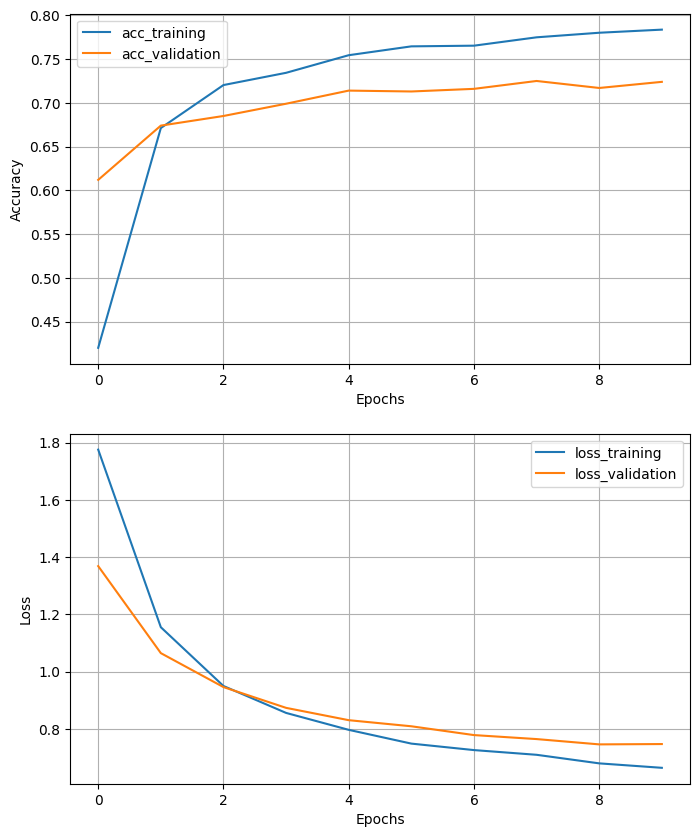

In [87]:
plot_learning_acc_and_loss(loss_train, accuracy_train, loss_val, accuracy_val)

In [88]:
test(RESNET18, dataloader_test=RES_dataloader_test)

Test Loss: 0.75150043 ---------- Test Accuracy: 74.4000%


Notice how we got this result by leveraging a model freely available on the internet and trained on another dataset. That's the power of transfer learning! 